#**Unsupervised flood detection with Sentinel 2 satellite imagery**

GIS Mini Project:
1. Rohaan Advani - 111903151
2. Varun Taneja - 111903158
3. Yash Dhake - 111903160

“SENTINEL-2 is a European wide-swath, high-resolution, multi-spectral imaging mission. The full mission specification of the twin satellites flying in the same orbit but phased at 180°, is designed to give a high revisit frequency of 5 days at the Equator. SENTINEL-2 carries an optical instrument payload that samples 13 spectral bands: four bands at 10 m, six bands at 20 m and three bands at 60 m spatial resolution. The orbital swath width is 290 km.”

**Libraries Required:**

1. **Geopandas:**
GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and matplotlib for plotting.

2. **Sentinelsat:**
Sentinelsat makes searching, downloading and retrieving the metadata of Sentinel satellite images from the Copernicus Open Access Hub easily.

3. **Rasterio:**
Rasterio is a highly useful module for raster processing which you can use for reading and writing several different raster formats in Python. Rasterio is based on GDAL and Python automatically registers all known GDAL drivers for reading supported formats when importing the module.

4. **Folium:**
Folium is a powerful Python library that helps you create several types of Leaflet maps. By default, Folium creates a map in a separate HTML file. Since Folium results are interactive, this library is very useful for dashboard building. You can also create inline Jupyter maps in Folium.

5. **cv2:**
OpenCV is a Python library that allows you to perform image processing and computer vision tasks. It provides a wide range of features, including object detection, face recognition, and tracking.

In [1]:
!pip install geopandas
!pip install sentinelsat
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 97.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 6.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 68.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import geopandas as gpd
from shapely import geometry
from shapely.geometry import Polygon
import folium
from sentinelsat.sentinel import SentinelAPI
import numpy as np
import zipfile
import rasterio
import os
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import cv2
import math
from IPython.display import Image

**Terminology:**
1. **Floodplain analysis using GIS:**
Remote sensing and GIS can provide spatial information, which can be effectively used for flood monitoring, forecasting and analysis. Flood modeling is also useful for flood management particularly to help solving flood inundation problem, which often occurs in the lower plain.

2. **Change Detection using GIS:**
In geographic information system (GIS), change detection is a process that measures how the attributes of a particular area have changed between two or more time periods. Change detection often involves comparing aerial photographs or satellite imagery of the area taken at different times.

We can create a geodataframe to represent the chosen location boundary from the associated latitude and longitude coords.

In [3]:
# create boundary file
def location(lon1, lon2, lat1, lat2):
    """
    location is a function to return a geodataframe with rectangular polygon
    geometry from 2 sets of lat/lon points.
    """ 
    p1 = geometry.Point(lon1,lat1)
    p2 = geometry.Point(lon2,lat1)
    p3 = geometry.Point(lon2,lat2)
    p4 = geometry.Point(lon1,lat2)
    pointList = [p1, p2, p3, p4, p1] # Closed Polygon

    poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    boundary = pd.DataFrame()
    boundary['geometry'] = [poly]
    boundary = gpd.GeoDataFrame(boundary, geometry='geometry', crs={'init': 'epsg:4326'})
    return boundary

## Study Area: St Ives United Kingdom:

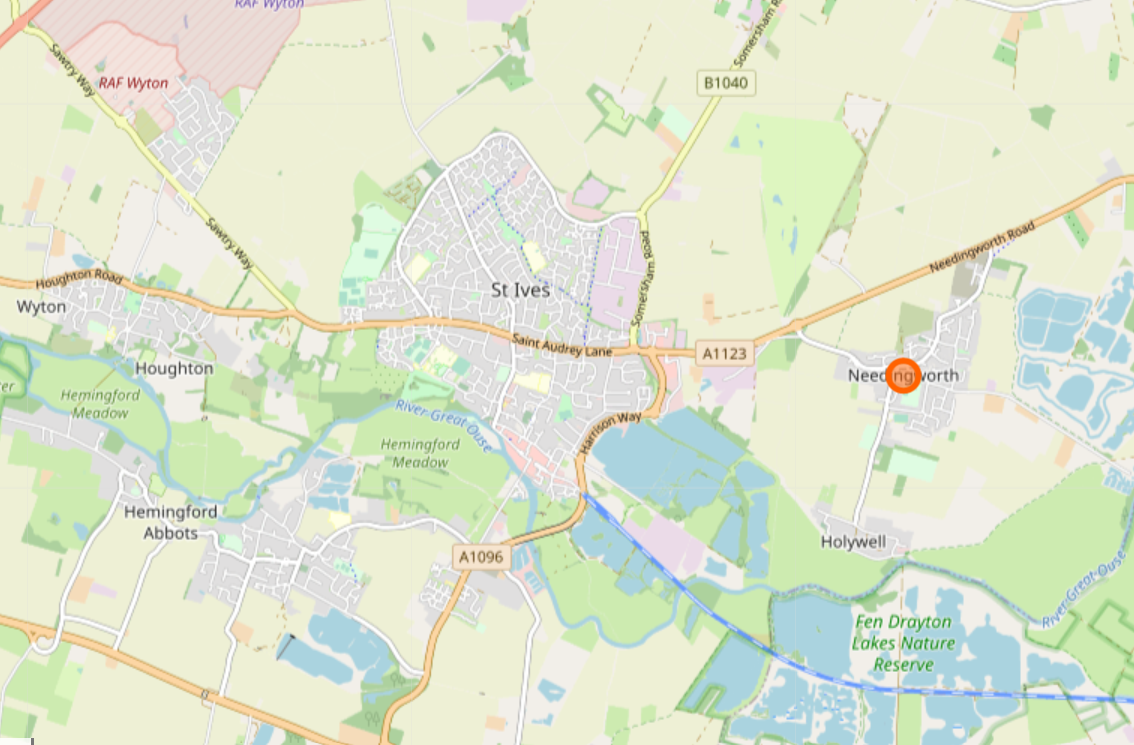

In [4]:
display(Image(filename='St Ives.png'))

To get Latitude and Longitude Coordinates, use open street map. Right-click on map and select show address to get location information.

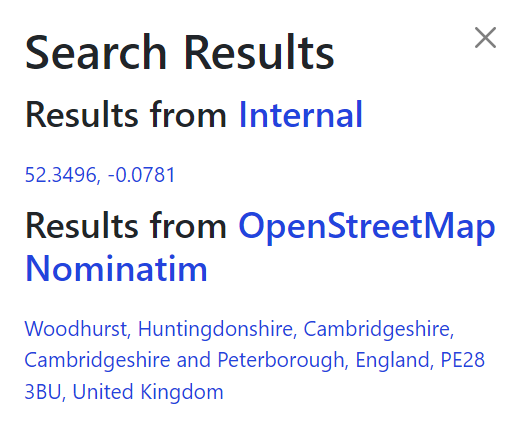

In [7]:
display(Image(filename='Loc.png'))

In [5]:
# St Ives Boundary
lat1 = 52.3494
lat2 = 52.2907
lon1 = -0.1095
lon2 = 0.0201

# visualise our polygon in folium  
m = folium.Map([(lat1+lat2)/2, (lon1+lon2)/2], zoom_start=13)
boundary = location(lon1, lon2, lat1, lat2)
print(boundary)

bound = folium.GeoJson(boundary, name='Boundary')
folium.Popup("Area of Interest").add_to(bound)
bound.add_to(m)
folium.LayerControl().add_to(m)
m

                                            geometry
0  POLYGON ((-0.10950 52.34940, 0.02010 52.34940,...


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


We’re going to take advantage of Sentinelsat, a python library for querying Sentinel mission data. First we need to register a username + password and then of course pip install sentinelsat.

This library connects to the Copernicus Open Access Hub where the imagery is archived. We provide the polygon and search for satellite images with an overlap of this area. We then also filter our results to search for images which contain 100% of our defined boundary.

In [8]:
geom = boundary['geometry'].iloc[0]

user = 'rohaan1611' 
password = 'Shivaan@0407'
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')
# St Ives date = ('20230101', '20230330')
products = api.query(geom,
                     date = ('20230101', '20230330'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0, 20))

gdf = api.to_geodataframe(products)
gdf_sorted = gdf.sort_values(by='ingestiondate')
# gdf_sorted = gdf

# filter results to show results that fully contain our desired boundary
polya = boundary['geometry'].iloc[0]
gdf_sorted['contains'] = gdf_sorted['geometry'].apply(lambda x:x.contains(polya))
gdf_sorted = gdf_sorted[gdf_sorted['contains']==True]

In [9]:
m = folium.Map([(lat1+lat2)/2, (lon1+lon2)/2], zoom_start=8)

bound = folium.GeoJson(boundary, name='Boundary')
folium.Popup("Area of Interest").add_to(bound)
bound.add_to(m)

for j,i in enumerate(gdf_sorted['geometry']):
    bound = folium.GeoJson(i, name='Sentinel_{}'.format(gdf_sorted['ingestiondate'].iloc[j]))
    bound.add_to(m)
    
folium.LayerControl().add_to(m)
m

The GDF Sorted variable contains all returns products on Copernicus Hub for the above query.

In [10]:
print(gdf_sorted)

                                                                                  title  \
a3a1e4a1-dc83-457a-8a06-df1fc5060fc6  S2A_MSIL2A_20230121T111351_N0509_R137_T30UXD_2...   
7c8858b6-f72d-41af-8cf6-8db7160494c3  S2A_MSIL2A_20230207T110221_N0509_R094_T30UXD_2...   
bc6030fa-c710-4f4f-8df3-bd5bf0609c4a  S2B_MSIL2A_20230215T111049_N0509_R137_T30UXD_2...   

                                                                                   link  \
a3a1e4a1-dc83-457a-8a06-df1fc5060fc6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
7c8858b6-f72d-41af-8cf6-8db7160494c3  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
bc6030fa-c710-4f4f-8df3-bd5bf0609c4a  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
a3a1e4a1-dc83-457a-8a06-df1fc5060fc6  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
7c8858b6-f72d-41af-8cf6-8db7160494c3  https://scihub.copernicus.eu/dhus/odata/v1/Pro... 

Check Copernicus Hub to confirm product availability

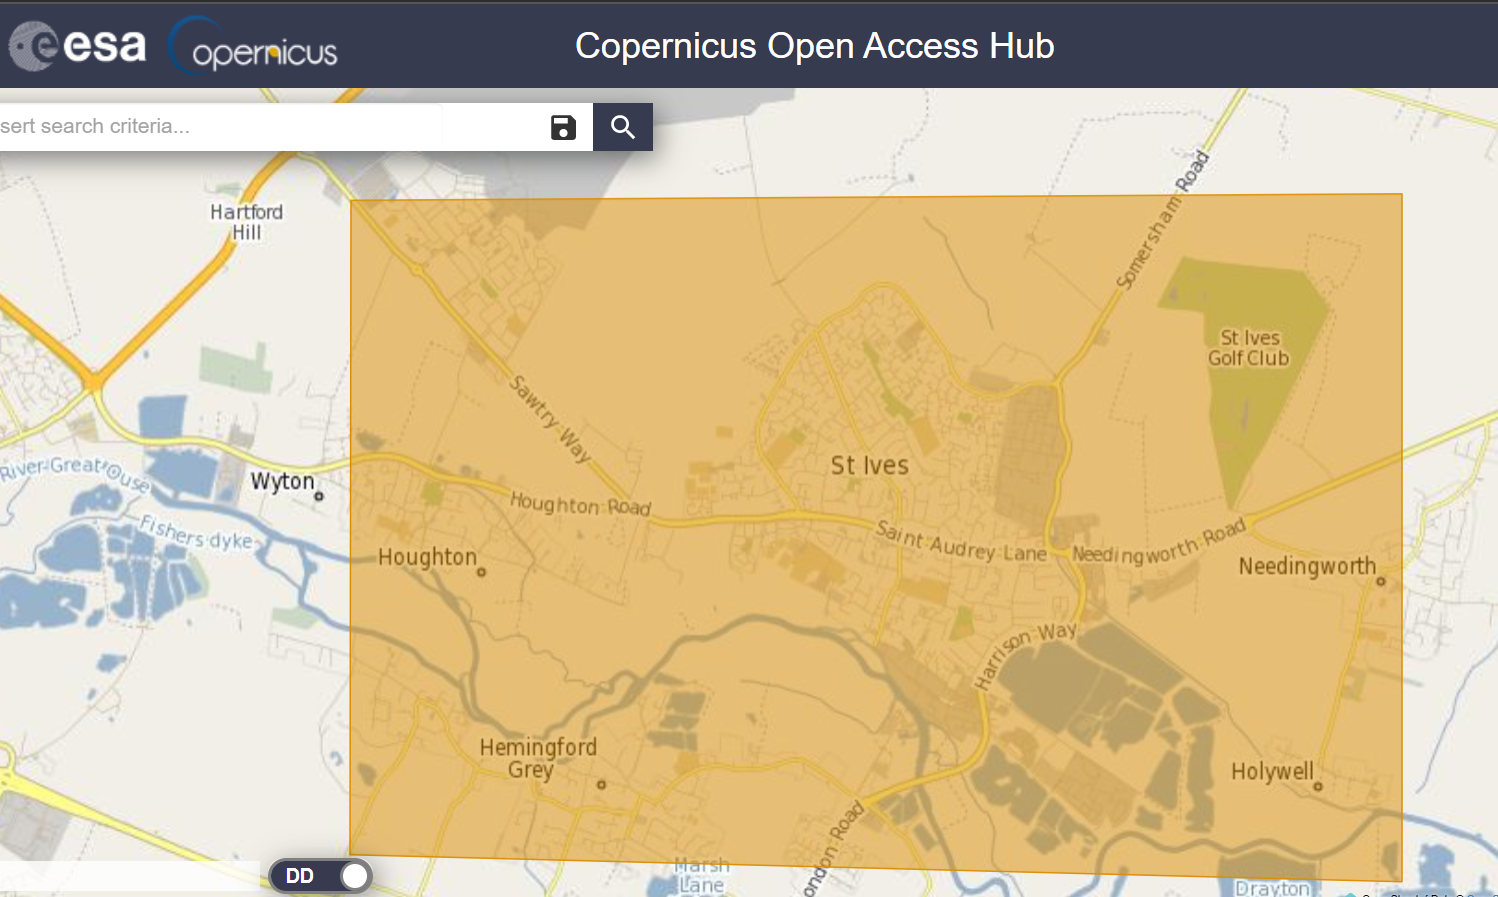

In [11]:
display(Image(filename='Cop1.png'))

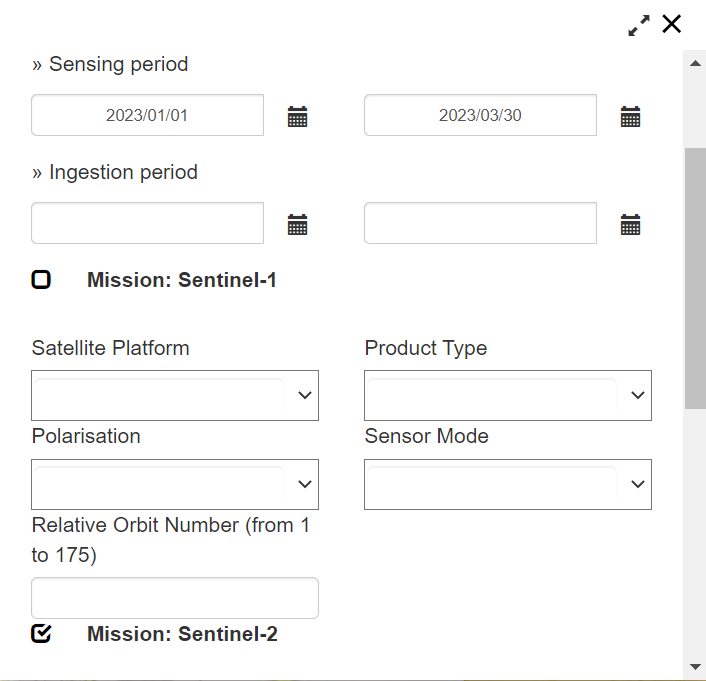

In [12]:
display(Image(filename='Cop2.png'))

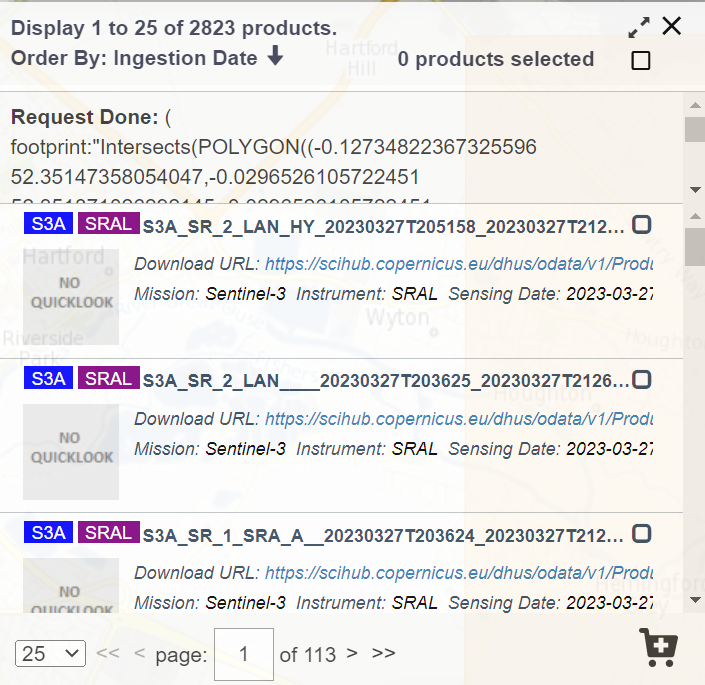

In [13]:
display(Image(filename='Cop3.png'))

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

EPSG:32630


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


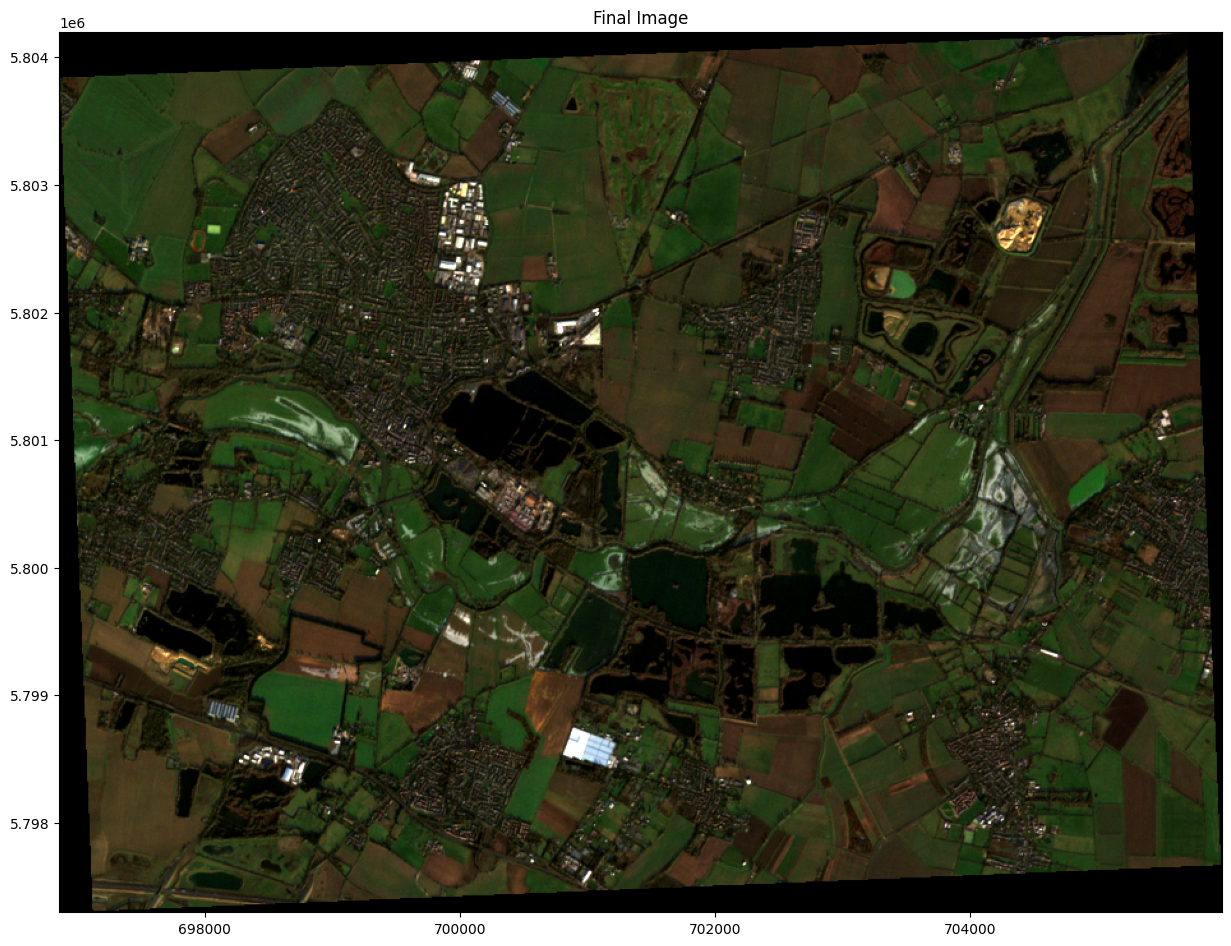

<Axes: title={'center': 'Final Image'}>

In [14]:
api.download(gdf_sorted.index[0])
meta = api.download(gdf_sorted.index[0])
folder = meta['title']

# unzip downloaded imagery
with zipfile.ZipFile('{}.zip'.format(folder), 'r') as zip_ref:
    zip_ref.extractall('')

folder = folder+'.SAFE'

# path to 10m resolution imagery directory
image_dir = '{}/GRANULE/{}/IMG_DATA/R10m'.format(folder,os.listdir(os.path.join(folder,'GRANULE'))[-1])
raw_image = sorted(os.listdir(image_dir))[-2]
image_path = os.path.join(image_dir,raw_image)

check = rasterio.open('{}'.format(image_path))
print(check.crs)

bound_crs = boundary.to_crs({'init': 'epsg:32630'})

# crop the satellite image to fit to our defined boundary
with rasterio.open('{}'.format(image_path)) as src:
    out_image, out_transform = mask(src, bound_crs.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# write cropped image
name = "StIves"
date = "2023-01-21"
filenames = []
filename = '{}_{}.png'.format(date,name)
filenames.append(filename)
with rasterio.open(filename, "w", **out_meta) as final:
    final.write(out_image)

# plot cropped image
src = rasterio.open(filename)
fig = plt.figure(figsize=(15,15))
plt.title('Final Image')
plot.show(src, adjust='linear')

MD5 checksumming:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

EPSG:32630


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


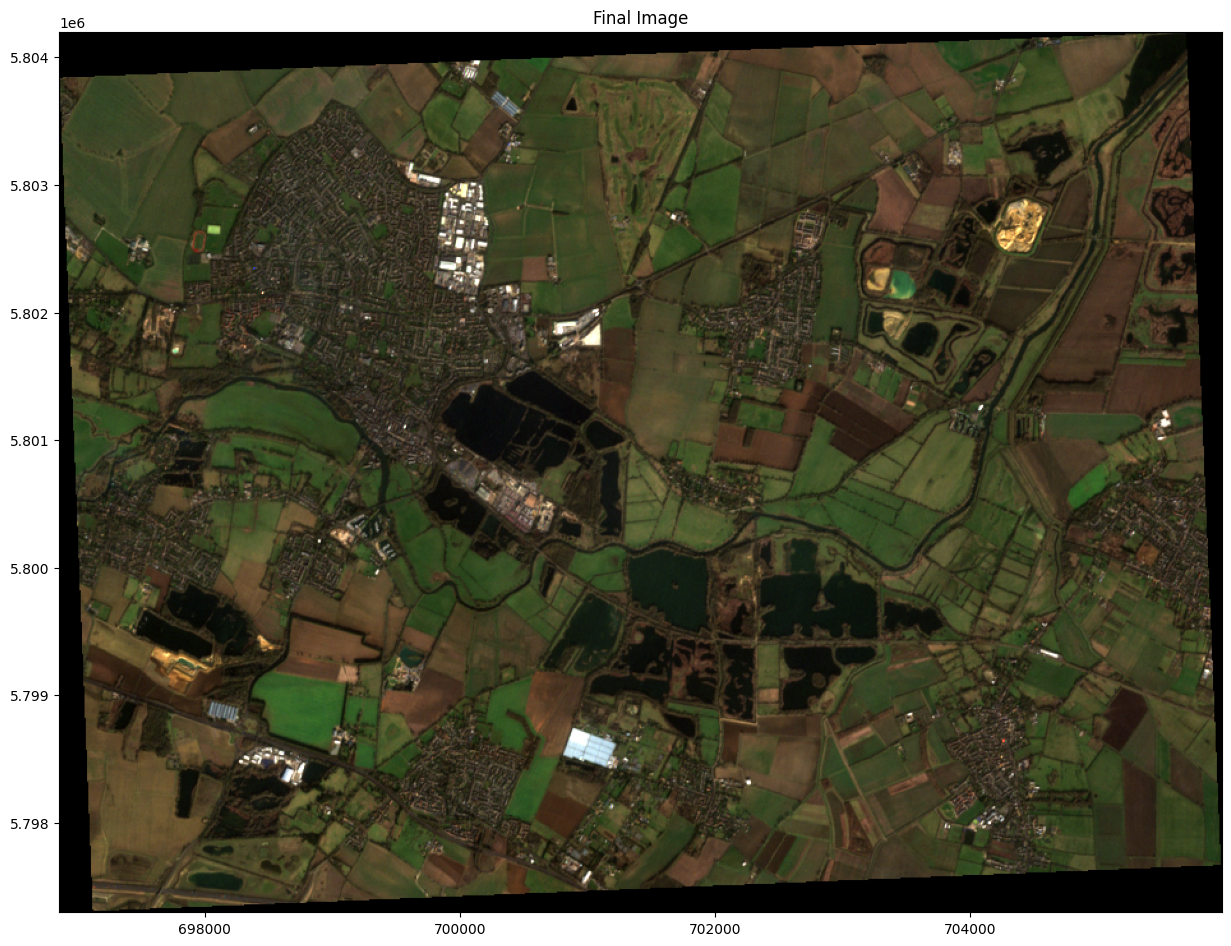

<Axes: title={'center': 'Final Image'}>

In [15]:
api.download(gdf_sorted.index[2])
meta = api.download(gdf_sorted.index[2])
folder = meta['title']

# unzip downloaded imagery
with zipfile.ZipFile('{}.zip'.format(folder), 'r') as zip_ref:
    zip_ref.extractall('')

folder = folder+'.SAFE'

# path to 10m resolution imagery directory
image_dir = '{}/GRANULE/{}/IMG_DATA/R10m'.format(folder,os.listdir(os.path.join(folder,'GRANULE'))[-1])
raw_image = sorted(os.listdir(image_dir))[-2]
image_path = os.path.join(image_dir,raw_image)

check = rasterio.open('{}'.format(image_path))
print(check.crs)

bound_crs = boundary.to_crs({'init': 'epsg:32630'})

# crop the satellite image to fit to our defined boundary
with rasterio.open('{}'.format(image_path)) as src:
    out_image, out_transform = mask(src, bound_crs.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# write cropped image
name = "StIves"
date = "2023-02-15"
filenames = []
filename = '{}_{}.png'.format(date,name)
filenames.append(filename)
with rasterio.open(filename, "w", **out_meta) as final:
    final.write(out_image)

# plot cropped image
src = rasterio.open(filename)
fig = plt.figure(figsize=(15,15))
plt.title('Final Image')
plot.show(src, adjust='linear')

You may also wish to apply some further crop and rotation to the images as they will likely be skewed.

In [16]:
def rotate_image(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    """
    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.
    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow
    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

def demo(imfile):
    """
    Demos the largest_rotated_rect function
    """

    image = cv2.imread(imfile)
    image_height, image_width = image.shape[0:2]

    print('file read')
    print('working...')
    for i in np.arange(0, 360, 0.5):
        image_rotated = rotate_image(image, i)
        image_rotated_cropped = crop_around_center(
            image_rotated,
            *largest_rotated_rect(
                image_width,
                image_height,
                math.radians(i)
            )
        )

        key = cv2.waitKey(2)
        if(key == ord("q") or key == 27):
            exit()
    
    cv2.imwrite(imfile, image_rotated_cropped)

    print("done")
    
# apply the function 4 times to achieve optimal crop for our image
for i in range(4):
    demo('2023-01-21_StIves.png')

for i in range(4):
    demo('2023-02-15_StIves.png')

file read
working...
done
file read
working...
done
file read
working...
done
file read
working...
done
file read
working...
done
file read
working...
done
file read
working...
done
file read
working...
done


So we have defined an area we want satellite imagery for and downloaded 2 images 1 month apart. Lets see whats going and why there was a perceived change in the terrain compostion.

An image is fundamentally a dataset containing pixels. Pixels contain RGB colour information and combining pixels vertically and horizontally give us our image. This information can be expressed in a vector, in our case we have two images with vectors of shape (height, width, RGB) where height = 670, width = 875, and RGB = 3.

If our images are the same size, we can create a new vector by calculating the difference between every corresponding pixel. If our images are correctly aligned, the pixels will be similar and the RBG values should be close to (0, 0, 0) and appear black when visualised. If not, we will see a coloured highlight where those differences appear.

In [17]:
import imageio

imagepath1 = '2023-01-21_StIves.png'
imagepath2 = '2023-02-15_StIves.png'

image1 = imageio.imread(imagepath1)
image2 = imageio.imread(imagepath2)
image1 = image1.astype(np.int16)
image2 = image2.astype(np.int16)
diff_image = abs(image1 - image2)

<ipython-input-17-0ad38226e91a>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(imagepath1)
<ipython-input-17-0ad38226e91a>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(imagepath2)


The next step is to use PCA & K-Means to produce a binary classification of significant changes between the two images.

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
import skimage

def find_vector_set(diff_image, new_size):
 
    i = 0
    j = 0
    vector_set = np.zeros((int(new_size[0] * new_size[1] / 75), 75))
    while i < vector_set.shape[0]:
        while j < new_size[0]:
            k = 0
            while k < new_size[1]:
                block   = diff_image[j:j+5, k:k+5]
                feature = block.ravel()
                vector_set[i, :] = feature
                k = k + 5
            j = j + 5
        i = i + 1
 
    mean_vec   = np.mean(vector_set, axis = 0)
    vector_set = vector_set - mean_vec
    return vector_set, mean_vec
 
def find_FVS(EVS, diff_image, mean_vec, new):
 
    i = 2
    feature_vector_set = []
 
    while i < new[0] - 2:
        j = 2
        while j < new[1] - 2:
            block = diff_image[i-2:i+3, j-2:j+3]
            feature = block.flatten()
            feature_vector_set.append(feature)
            j = j+1
        i = i+1
 
    FVS = np.dot(feature_vector_set, EVS)
    FVS = FVS - mean_vec
    print("\nfeature vector space size", FVS.shape)
    return FVS
 
def clustering(FVS, components, new):
 
    kmeans = KMeans(components, verbose = 0)
    kmeans.fit(FVS)
    output = kmeans.predict(FVS)
    count  = Counter(output)
 
    least_index = min(count, key = count.get)
    change_map  = np.reshape(output,(new[0] - 4, new[1] - 4))
    return least_index, change_map
 
def find_PCAKmeans(imagepath1, imagepath2):
 
    image1 = imageio.imread(imagepath1)
    image2 = imageio.imread(imagepath2)
 
    new_size = np.asarray(image1.shape) / 5
    new_size = new_size.astype(int) * 5
    #image1 = skimage.transform.resize(image1, (new_size)).astype(np.int16)
    #image2 = skimage.transform.resize(image2, (new_size)).astype(np.int16)
    image1 = image1.astype(np.int16)
    image2 = image2.astype(np.int16)
    
    diff_image = abs(image1 - image2)
    
    #print(diff_image)
    
    vector_set, mean_vec = find_vector_set(diff_image, new_size)
    pca     = PCA()
    pca.fit(vector_set)
    EVS = pca.components_
 
    FVS     = find_FVS(EVS, diff_image, mean_vec, new_size)
    components = 2
    least_index, change_map = clustering(FVS, components, new_size)
 
    change_map[change_map == least_index] = 255
    change_map[change_map != 255] = 0
 
    change_map = change_map.astype(np.uint8)
    kernel     = np.asarray(((0,1,1,1,0),
                             (1,1,1,1,0),
                             (1,1,1,1,1),
                             (1,1,1,1,1),
                             (0,1,1,1,0)), dtype=np.uint8)
    cleanChangeMap = cv2.erode(change_map,kernel)
    imageio.imwrite("{}_{}_diff.png".format(imagepath1[:-4],imagepath2[:-4]), cleanChangeMap)

In [19]:
find_PCAKmeans(imagepath1, imagepath2)

<ipython-input-18-30824f46733f>:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(imagepath1)
<ipython-input-18-30824f46733f>:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(imagepath2)



feature vector space size (563766, 75)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


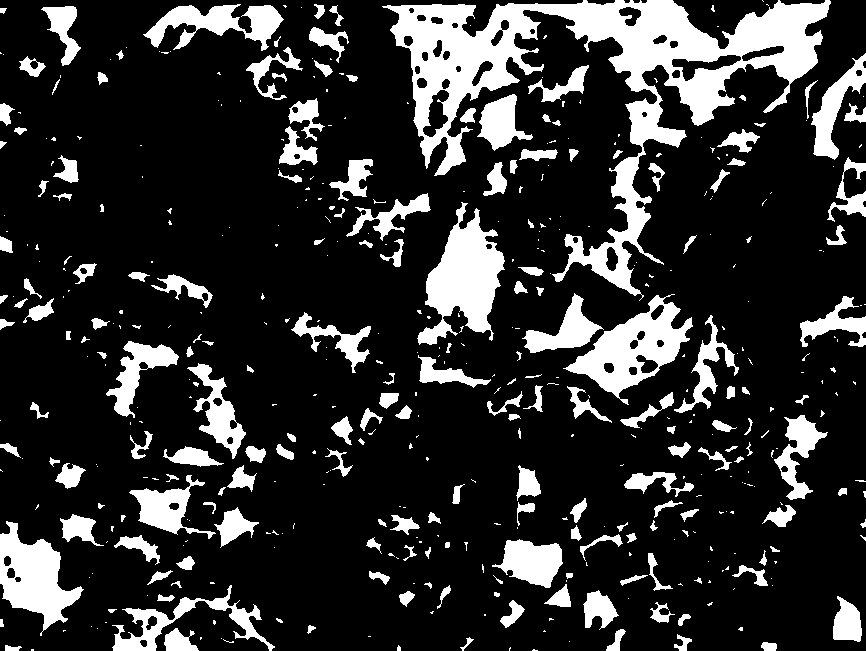

In [20]:
display(Image(filename='2023-01-21_StIves_2023-02-15_StIves_diff.png'))

In [22]:
# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse, diff

def analyse_change(image1, image2, diffimg):
  img = cv2.imread(diffimg)
  h, w, c = img.shape
  number_of_white_pix = np.sum(img == 255)
  print('Number of changed pixels:', number_of_white_pix)
  print('Total pizels:', h*w)
  print('% change:', 100*(number_of_white_pix/(h*w)))
  # load the input images
  img1 = cv2.imread(image1)
  img2 = cv2.imread(image2)

  # convert the images to grayscale
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

  error, diff = mse(img1, img2)
  print("Image matching Error between the two images:",error)

analyse_change('2023-01-21_StIves.png', '2023-02-15_StIves.png', '2023-01-21_StIves_2023-02-15_StIves_diff.png')

Number of changed pixels: 318363
Total pizels: 563766
% change: 56.47076978746502
Image matching Error between the two images: 2.6880184115026595


Can use these functions for other flood satellite images as shown below:

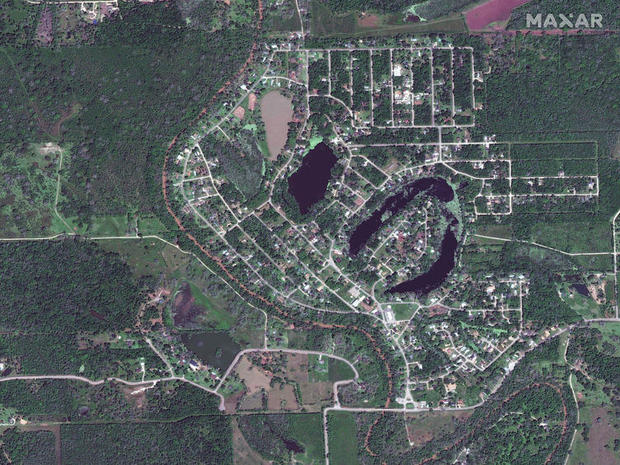

In [23]:
display(Image(filename='before.jpg'))

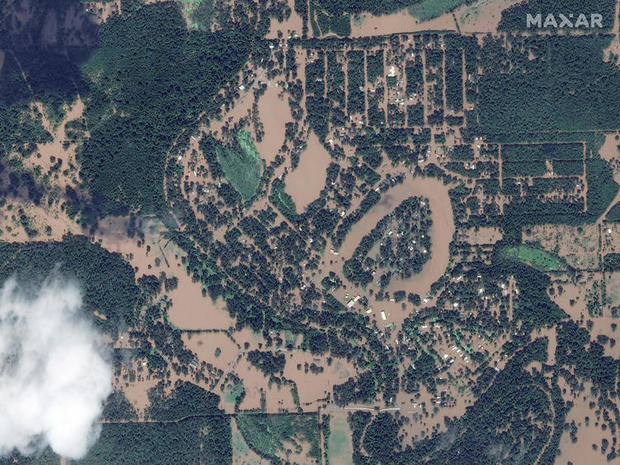

In [24]:
display(Image(filename='after.jpg'))

In [25]:
find_PCAKmeans('before.jpg', 'after.jpg')
analyse_change('before.jpg', 'after.jpg', 'before_after_diff.png')

<ipython-input-18-30824f46733f>:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(imagepath1)
<ipython-input-18-30824f46733f>:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(imagepath2)



feature vector space size (283976, 75)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of changed pixels: 52947
Total pizels: 283976
% change: 18.644885483280277
Image matching Error between the two images: 49.985834200485606


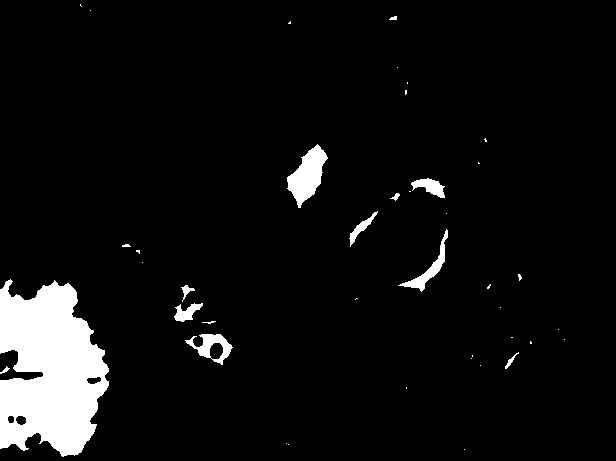

In [27]:
display(Image(filename='before_after_diff.png'))

In [26]:
find_PCAKmeans('before1.jpg', 'after1.jpg')
analyse_change('before1.jpg', 'after1.jpg', 'before1_after1_diff.png')

<ipython-input-18-30824f46733f>:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(imagepath1)
<ipython-input-18-30824f46733f>:59: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(imagepath2)



feature vector space size (713216, 75)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of changed pixels: 348744
Total pizels: 713216
% change: 48.89738872936109
Image matching Error between the two images: 55.244413888888886


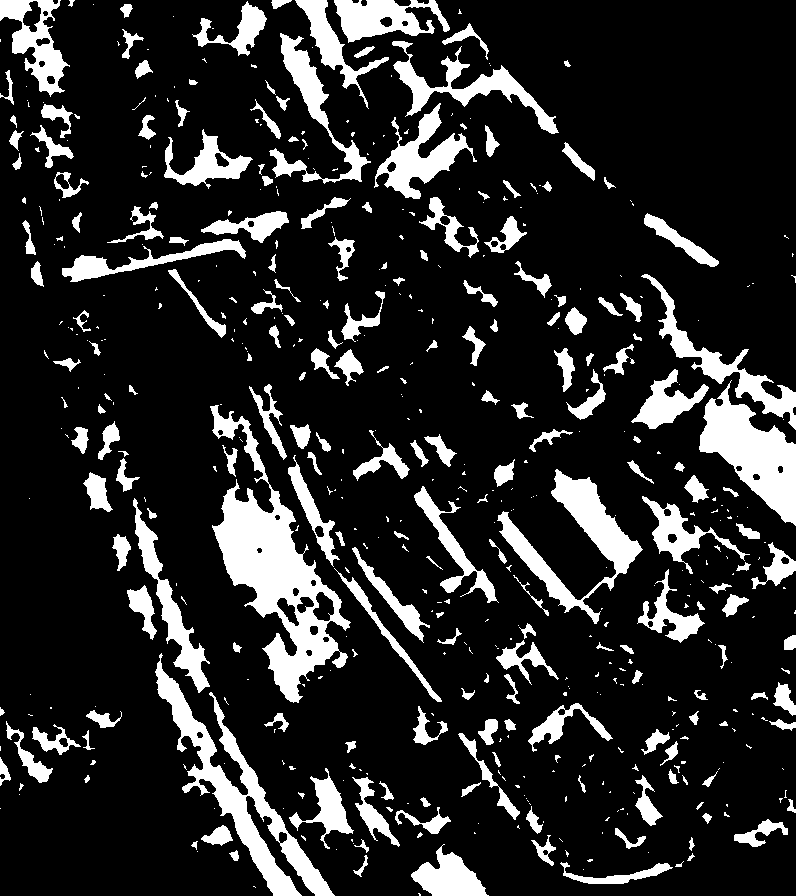

In [28]:
display(Image(filename='before1_after1_diff.png'))